<a href="https://colab.research.google.com/github/zahrael97/CT_scan_Covid19_CNN/blob/master/Inception/Ct_Inceptionv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Covid Detection using Transfer Learning**

In [1]:
# importing all the required libraries and modules

import numpy as np
import os, random
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import InceptionV3
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wEin2amP48r7ec3AlZ5WTlApEM4g05t2MxRdVcNd33ldp7umsdiSFo
Mounted at /content/drive


In [3]:
# Path of various directories
# Dataset : Chest X-Ray Images (Pneumonia) from Kaggle 

TRAIN_DIR = '/content/drive/My Drive/datasetCt/train'
TEST_DIR = '/content/drive/My Drive/datasetCt/test'
#VAL_DIR = '/content/drive/My Drive/chest_xray/val'

Covid_train = '/content/drive/My Drive/datasetCt/train/covid'
normal_train = '/content/drive/My Drive/datasetCt/train/normal'

Covid_test = '/content/drive/My Drive/datasetCt/test/covid'
normal_test = '/content/drive/My Drive/datasetCt/test/normal'

#pneumonia_val = '/content/drive/My Drive/chest_xray/val/PNEUMONIA'
#normal_val = '/content/drive/My Drive/chest_xray/val/NORMAL'

# **Customizing the Inceptionv3 model**

In [4]:
base_model=InceptionV3(weights='imagenet',include_top=False, input_shape=(224,224,3)) #imports the inceptionv3 model 
# and slices off the top layer which is the one that classifies objects into various classes (we don't want this layer)

# Setting up the pre-trained weights of the inceptionv3 model as non-trainable
for layer in base_model.layers:
    layer.trainable=False       

# Adding new layers on top of the base model
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation - here, we have only 2 classes (Pneumonia & Normal)

87916544/87910968 [==============================] - 2s 0us/step


In [6]:
# Specify the inputs
# Specify the outputs
model=Model(inputs=base_model.inputs,outputs=preds)

# A new model has been created based on our architecture
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [7]:
# Name of all the layers in our new model which is built on top of the Inceptionv3 model (look at No. 311 till final layer)
for i,layer in enumerate(model.layers):
  print(i,layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

## **Data Preparation**

In [8]:
def dir_file_count(directory):
  #Total number of files present inside the 'directory'
  return sum([len(files) for r, d, files in os.walk(directory)])

# Configuration parameters 
rescale = 1./255
target_size = (224, 224)
batch_size = 32            #Specifying the batch size
class_mode = 'categorical'

# Augment the training dataset images 
train_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
# Load the images in the generator 
train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=target_size,
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)
# Augment the validation dataset images
#val_datagen = ImageDataGenerator(rescale=rescale)
# Load the images in the generator
#val_generator = val_datagen.flow_from_directory(VAL_DIR, 
  #                                              target_size=target_size,
  #                                              class_mode=class_mode,
  #                                              batch_size=dir_file_count(VAL_DIR),
    #                                            shuffle=False)
# Augment the test dataset images
test_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
# Load the images in the generator
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size=target_size,
                                                  class_mode=class_mode,
                                                  batch_size=dir_file_count(TEST_DIR),
                                                  shuffle=False)

Found 618 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


# **Training Process of our custom model**

In [9]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# Loss function will be categorical cross entropy
# Evaluation metric will be accuracy

# Start the training
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=15,                                # Specifying the no. of epochs
                              validation_data=test_generator,
                              validation_steps=len(test_generator))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
20/20 [==============================] - 316s 16s/step - loss: 1.3146 - accuracy: 0.5129 - val_loss: 0.6857 - val_accuracy: 0.5462
Epoch 2/15
20/20 [==============================] - 13s 626ms/step - loss: 0.7229 - accuracy: 0.5388 - val_loss: 0.6733 - val_accuracy: 0.5769
Epoch 3/15
20/20 [==============================] - 12s 620ms/step - loss: 0.5997 - accuracy: 0.6780 - val_loss: 0.6806 - val_accuracy: 0.6385
Epoch 4/15
20/20 [==============================] - 13s 627ms/step - loss: 0.5385 - accuracy: 0.7346 - val_loss: 0.6570 - val_accuracy: 0.6308
Epoch 5/15
20/20 [==============================] - 12s 619ms/step - loss: 0.4514 - accuracy: 0.7799 - val_loss: 0.6539 - val_accuracy: 0.6462
Epoch 6/15
20/20 [==============================] - 12s 619ms/step - loss: 0.4638 - accuracy: 0.7848 - val_loss: 0.6320 - val_accuracy: 0.6462
Epoch 7/15
20/20 [==============================] - 12s 614ms/step 

# **Evaluation metrics (Performance)**

In [10]:
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
y_pred = y_pred.argmax(axis=-1)
y_true = test_generator.classes

precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred) 
confusion = confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize=None)
print("-"*70)
print("Report")
print("-"*70)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*70)
print("\n\n")

cls_report_print = classification_report(y_true, y_pred, target_names=['covid', 'Normal'])

cls_report = classification_report(y_true, y_pred, target_names=['covid', 'Normal'], output_dict=True)

print("-"*70)
print("covid Prediction")
print("-"*70)
print(cls_report_print)
print("-"*70)

print("confusion matrix    :" , confusion)

Instructions for updating:
Please use Model.predict, which supports generators.
1/1 [==============================] - 1s 560ms/step
----------------------------------------------------------------------
Report
----------------------------------------------------------------------
Precision     : 62.22%
Recall        : 86.15%
F1-Score      : 72.26%
----------------------------------------------------------------------



----------------------------------------------------------------------
covid Prediction
----------------------------------------------------------------------
              precision    recall  f1-score   support

       covid       0.78      0.48      0.59        65
      Normal       0.62      0.86      0.72        65

    accuracy                           0.67       130
   macro avg       0.70      0.67      0.66       130
weighted avg       0.70      0.67      0.66       130

----------------------------------------------------------------------
confusion matrix  

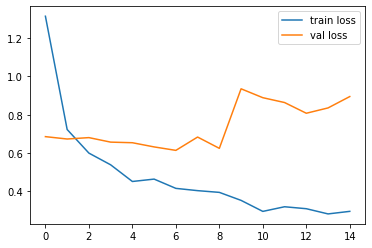

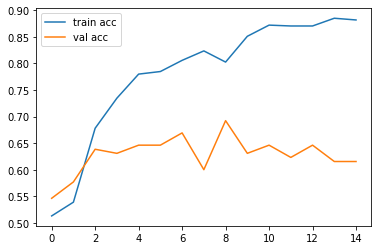

<Figure size 432x288 with 0 Axes>

In [11]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_accuracy')

import tensorflow as tf

from keras.models import load_model

model.save('InceptionV3.h5')